## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
        cv2.imwrite("../output_images/calibration/"+fname[14:],img)

cv2.destroyAllWindows()

## Then, I will perform camera calibration and image distortion correction using one of the chessboard images and test images.

In [3]:
def undistort_image(img,obj_p,img_p):
    
    # Applying the Grayscale transform
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  
    
    # Camera calibration, given object points, image points, and the shape of the grayscale image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_p, img_p, gray.shape[::-1], None, None)

    # Image distortion correction
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undistorted_img

## Undistorting one of the chessboard images:

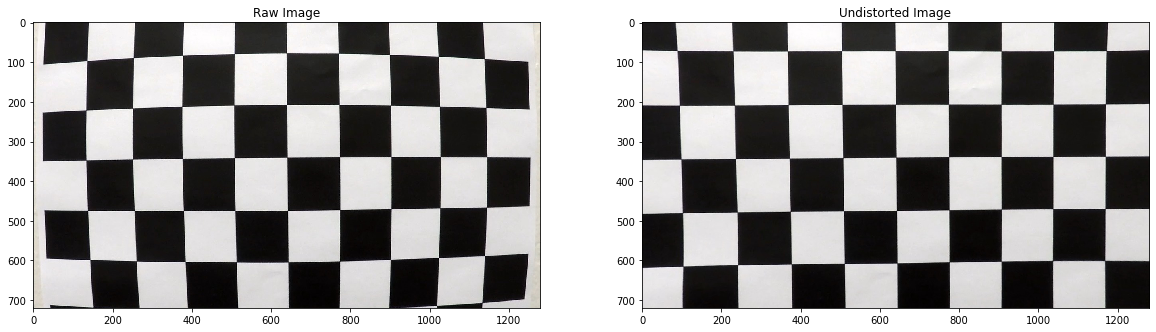

In [4]:
# Reading a Chessboard Image
image = cv2.imread('../camera_cal/calibration1.jpg')
undistorted_image = undistort_image(image,objpoints,imgpoints)

image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) 
undistorted_image_rgb = cv2.cvtColor(undistorted_image,cv2.COLOR_BGR2RGB)

# Vizualize raw image and undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Raw Image')
ax1.imshow(image_rgb)
ax2.set_title('Undistorted Image')
ax2.imshow(undistorted_image_rgb);

## Undistorting one of the test images:

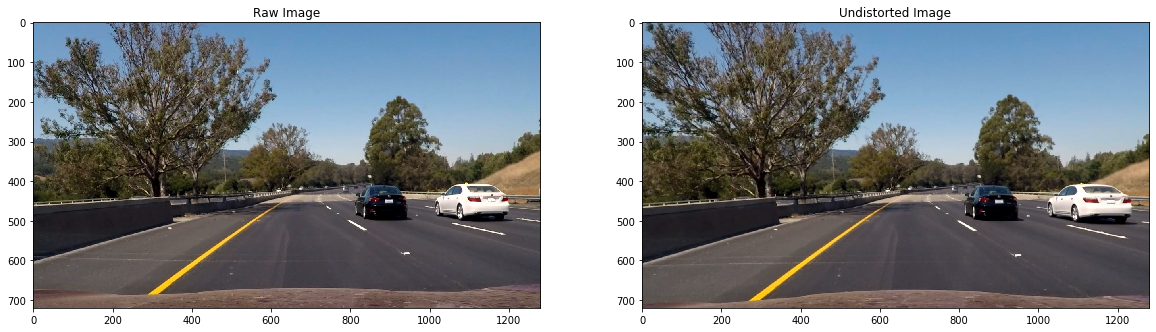

In [5]:
# Reading a Test Image
test_image = cv2.imread('../test_images/test6.jpg')
undistorted_test_image = undistort_image(test_image,objpoints,imgpoints)

test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
undistorted_test_image_rgb = cv2.cvtColor(undistorted_test_image, cv2.COLOR_BGR2RGB)

# Vizualize raw image and undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Raw Image')
ax1.imshow(test_image_rgb)
ax2.set_title('Undistorted Image')
ax2.imshow(undistorted_test_image_rgb);

## Applying sobel thresholds (Absolute, Magnitude and Direction)

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        print ("There isn't such orientation")
        return
    
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return this mask as grad_binary image
    return grad_binary

# Calculate gradient magnitude
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    
    # Calculate the magnitude 
    sobel_mag = np.sqrt(np.square(sobelx)+np.square(sobely))
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    
    # Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # Return this mask as mag_binary image
    return mag_binary

# Computes the direction of the gradient and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    sobel = np.arctan2(abs_sobely, abs_sobelx)
    
    # Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(sobel)
    dir_binary[(sobel >= thresh[0]) & (sobel <= thresh[1])] = 1
    
    # Return this mask as your binary_output image
    return dir_binary

## Applying these thresholds for the test image I've just undistorted

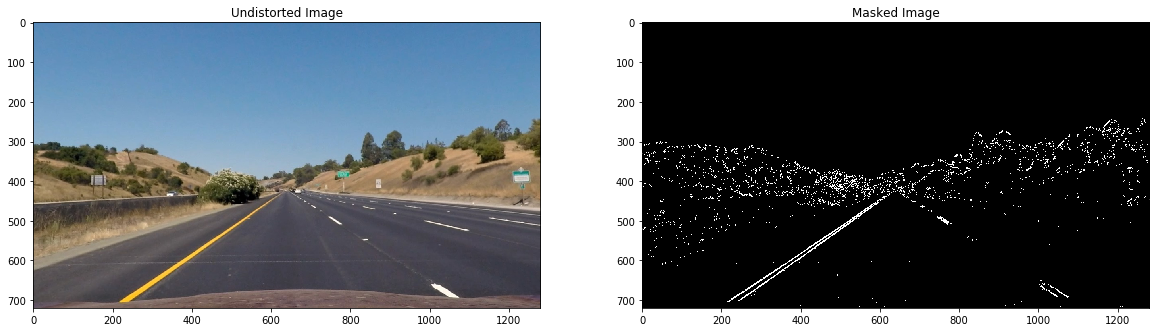

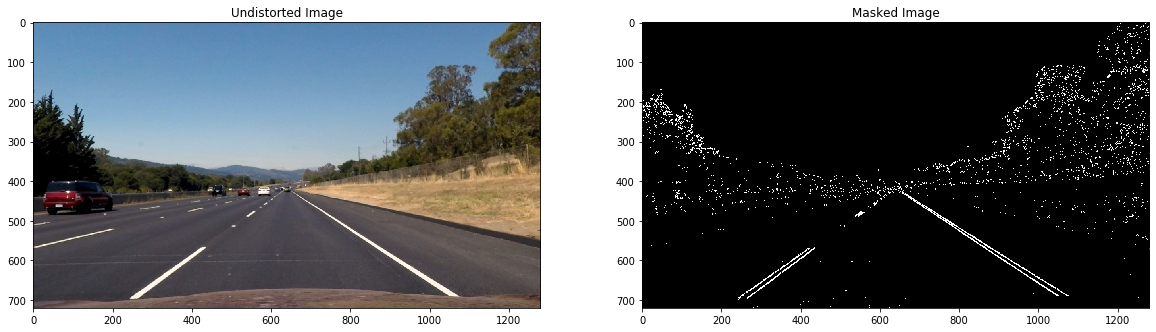

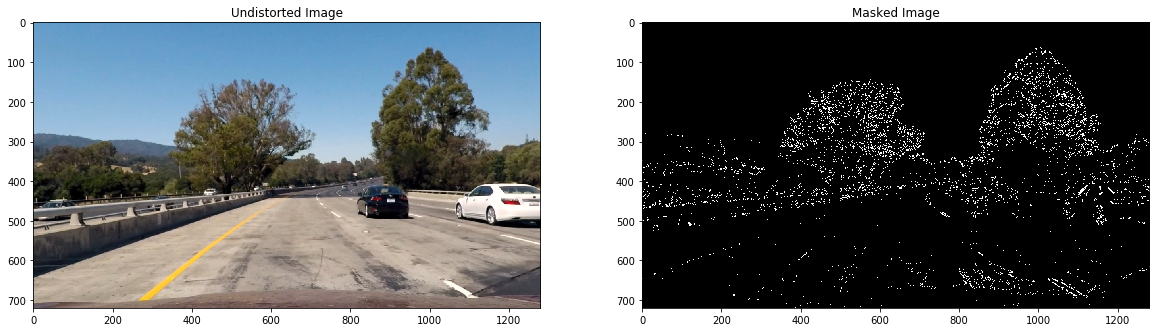

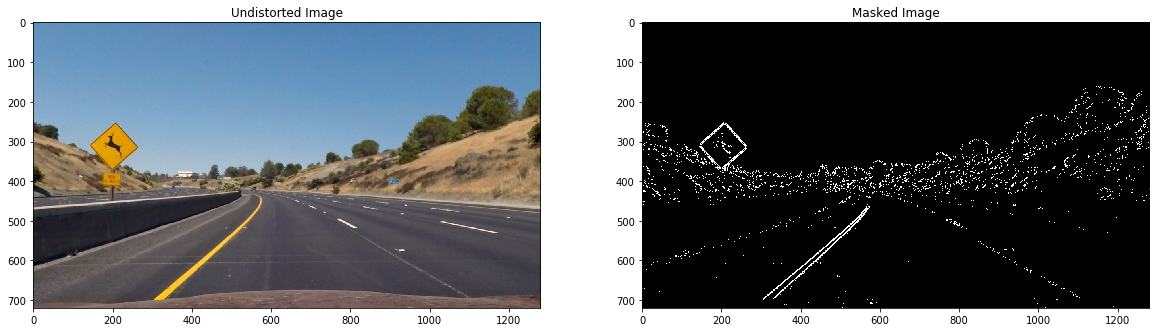

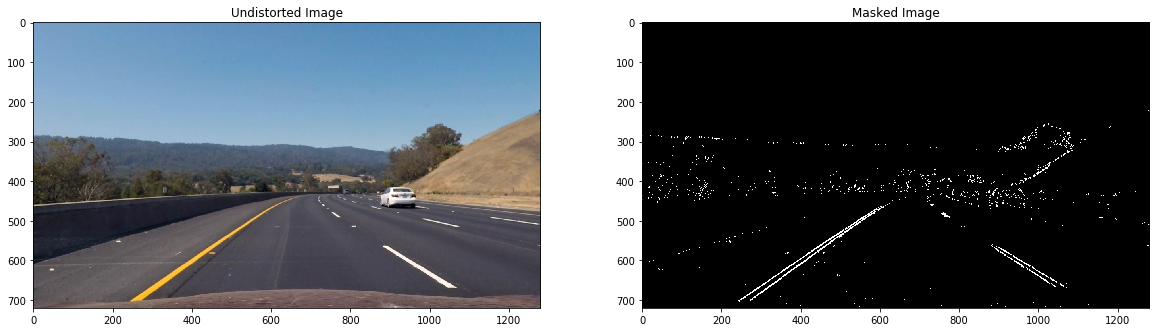

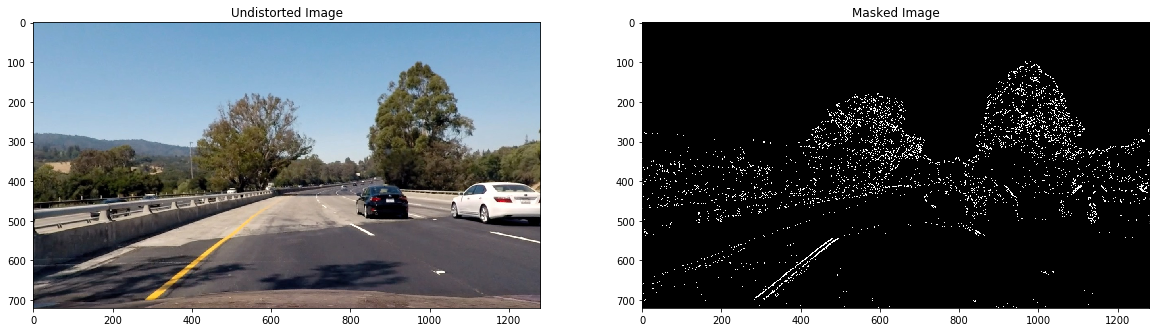

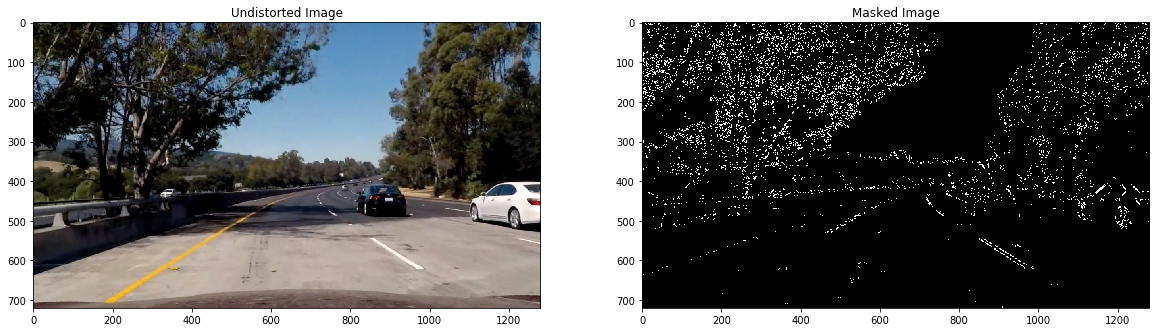

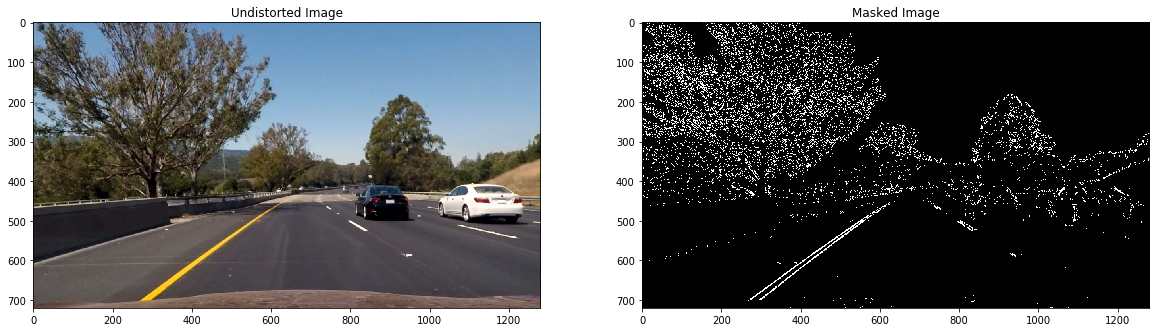

In [586]:
test_images = glob.glob('../test_images/*.jpg')
for fname in test_images:
    img = cv2.imread(fname)
    undistorted_img = undistort_image(img,objpoints,imgpoints)
    undistorted_img_rgb = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(undistorted_img, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(undistorted_img, orient='y', sobel_kernel=ksize, thresh=(10, 255))
    mag_binary = mag_thresh(undistorted_img, sobel_kernel=ksize, mag_thresh=(25, 255))
    dir_binary = dir_threshold(undistorted_img, sobel_kernel=ksize, thresh=(0.50, 1.10))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) | (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Vizualize undistorted image and masked image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Undistorted Image')
    ax1.imshow(undistorted_img_rgb)
    ax2.set_title('Masked Image')
    ax2.imshow(combined,cmap='gray');

## Applying Color Thresholds

In [577]:
# Thresholds the L-channel of HLS
def hls_select(img, s_thresh=(0, 255), l_thresh=(0, 255), h_thresh =(0, 255)):
    
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    # Apply a threshold to the L channel
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > s_thresh[0]) & (S <= s_thresh[1]) & (L > l_thresh[0]) & (L <= l_thresh[1]) & (H > h_thresh[0]) & (H <= h_thresh[1])] = 1
    
    # Return a binary image of threshold result
    return binary

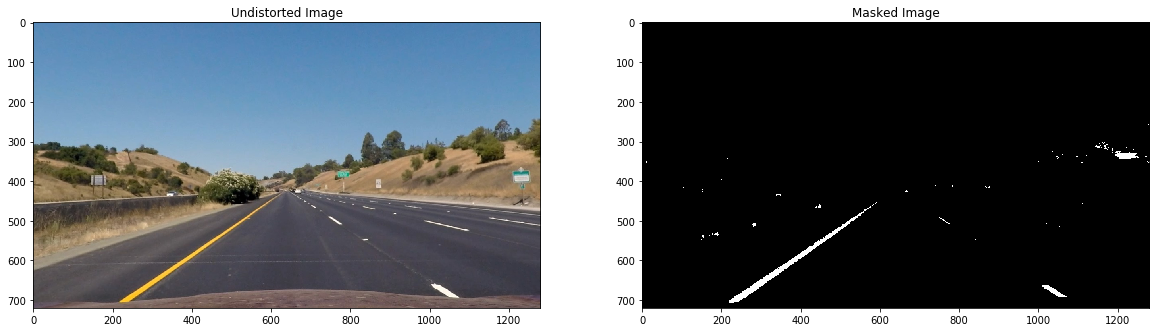

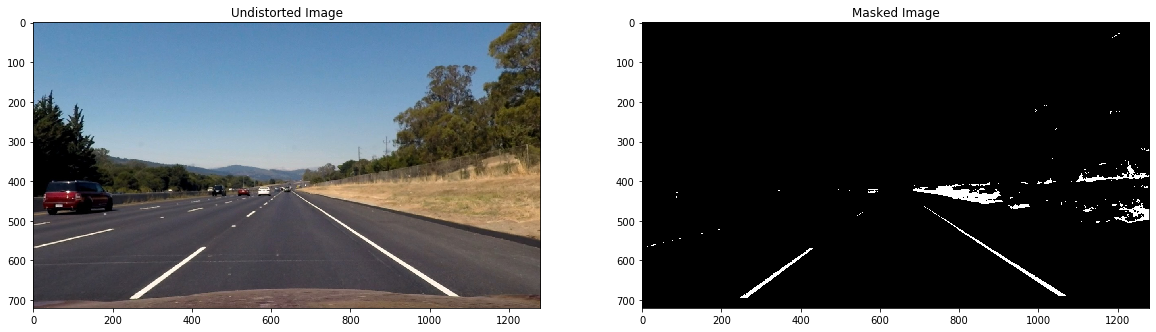

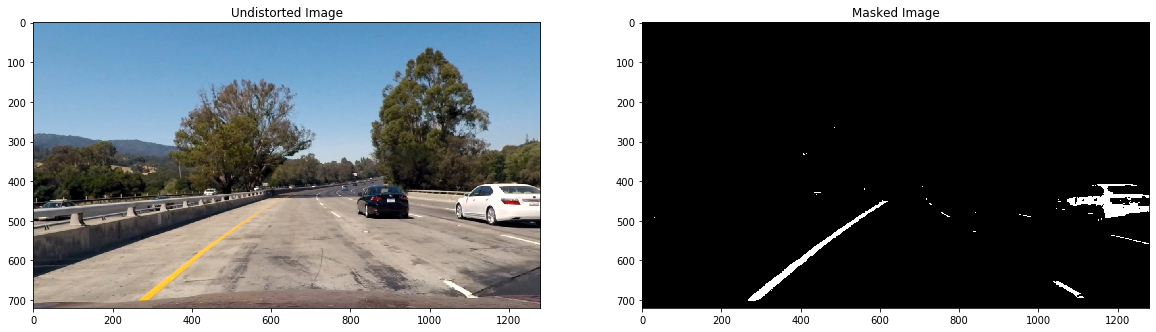

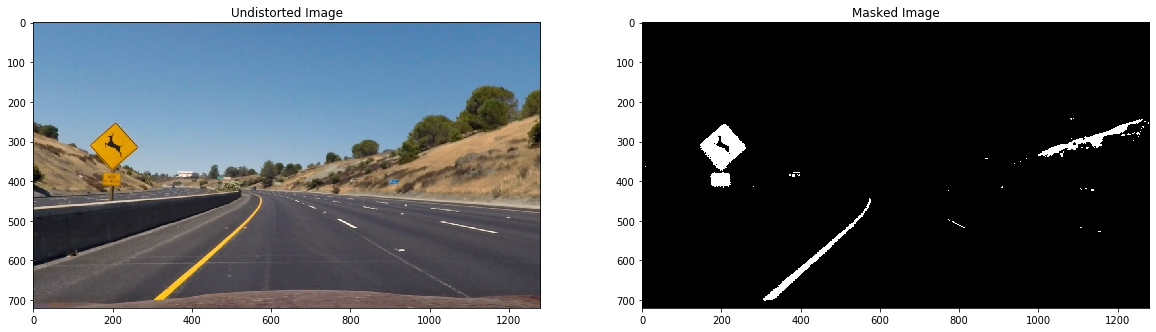

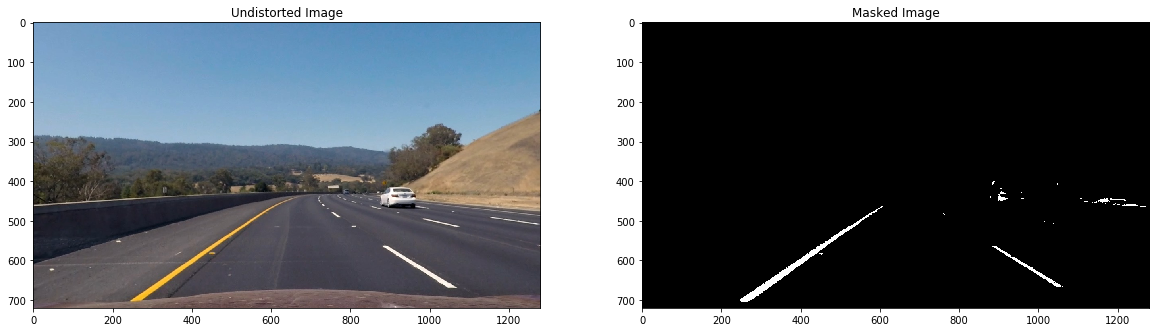

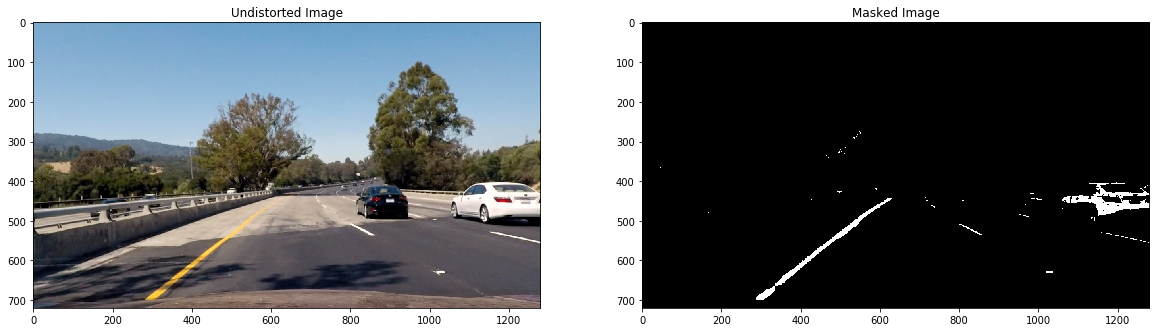

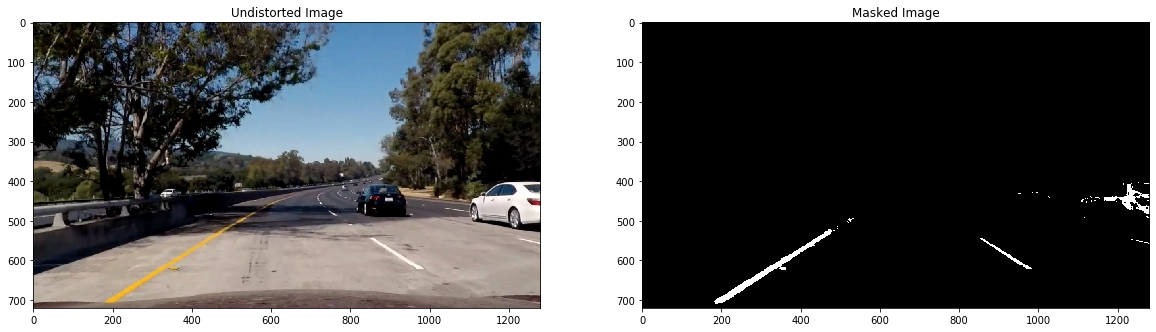

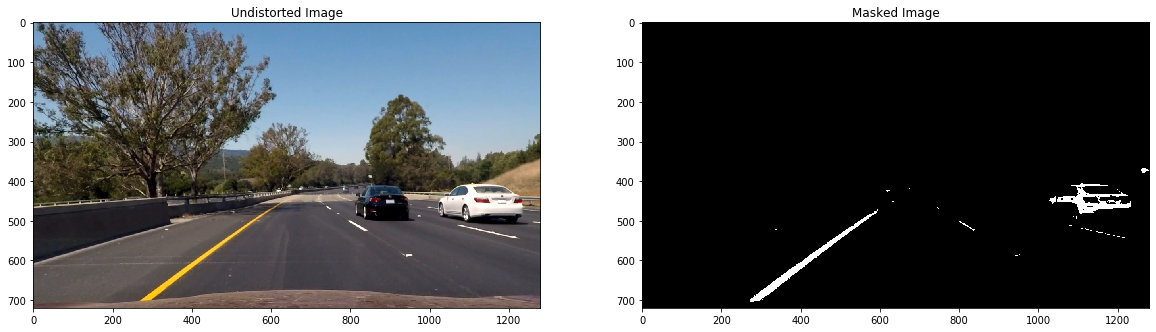

In [592]:
test_images = glob.glob('../test_images/*.jpg')
for fname in test_images:
    img = cv2.imread(fname)
    undistorted_img = undistort_image(img,objpoints,imgpoints)
    undistorted_img_rgb = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    
    # apply color threshold
    hls_binary = hls_select(undistorted_img, s_thresh=(110, 255),l_thresh=(65, 255),h_thresh=(0, 60))

    # Vizualize undistorted image and masked image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Undistorted Image')
    ax1.imshow(undistorted_img_rgb)
    ax2.set_title('Masked Image')
    ax2.imshow(hls_binary,cmap='gray');

## Combine Color and Gradient Thresholding

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


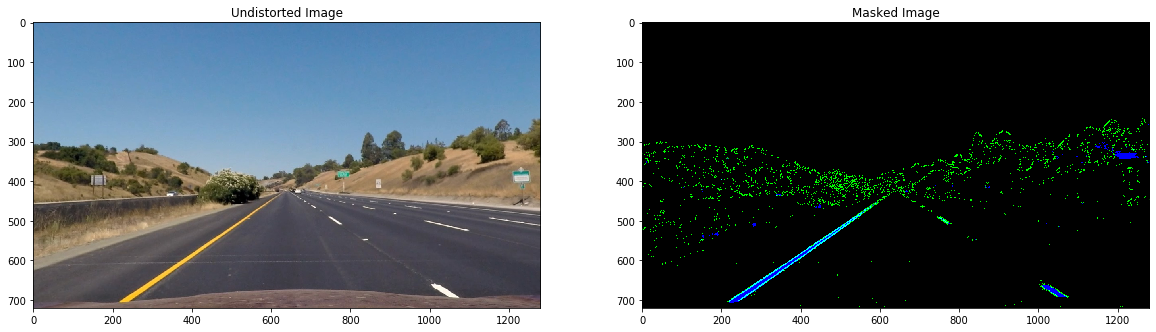

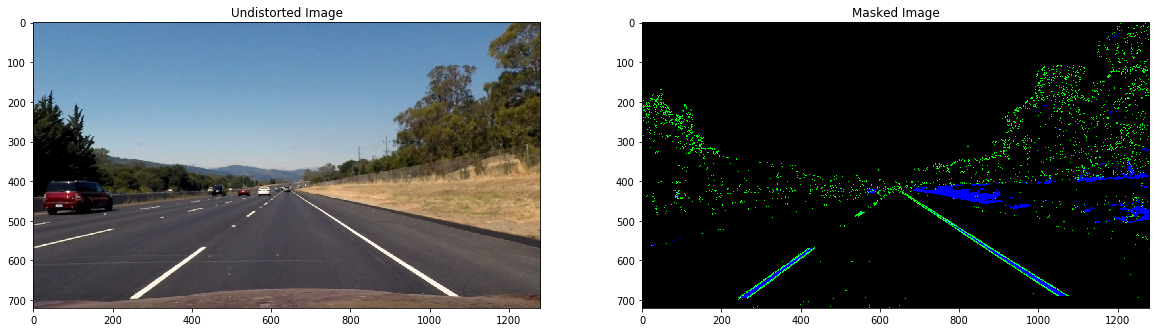

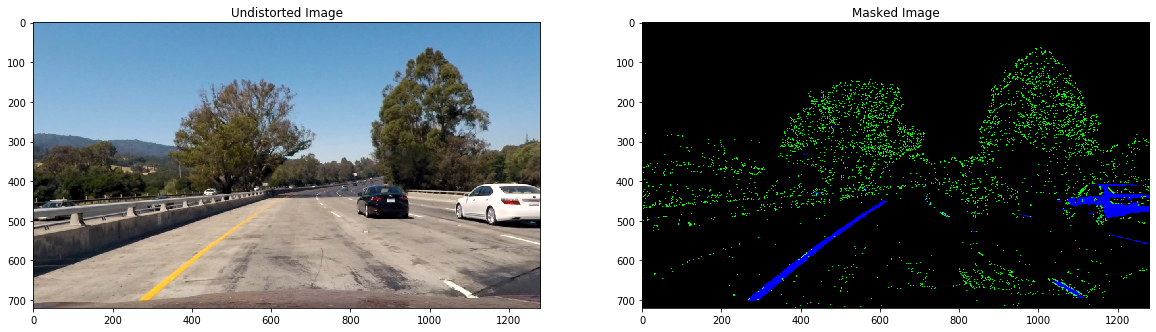

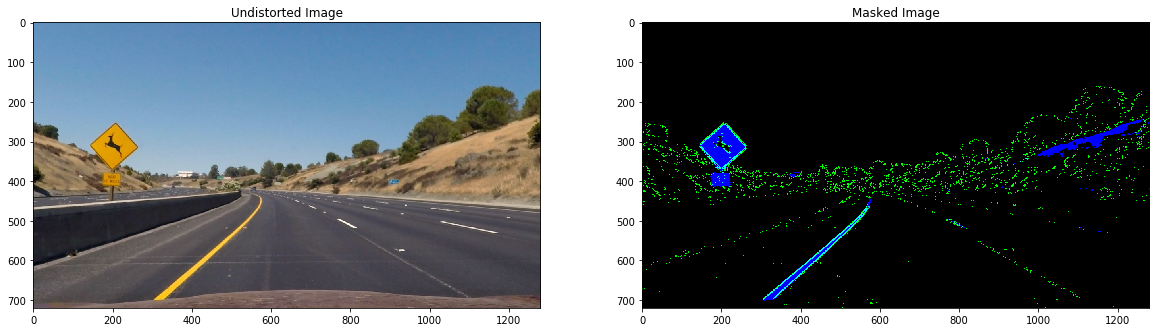

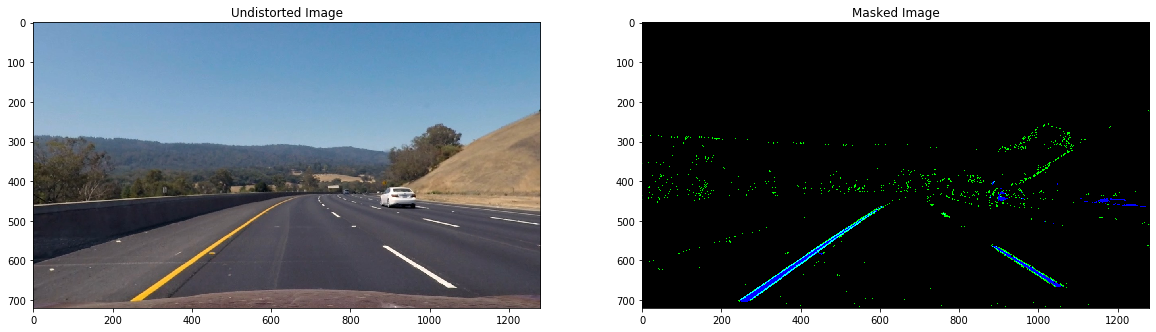

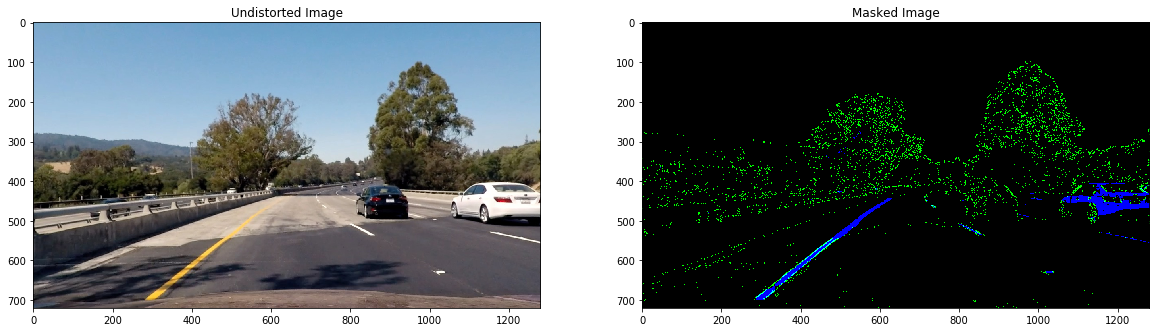

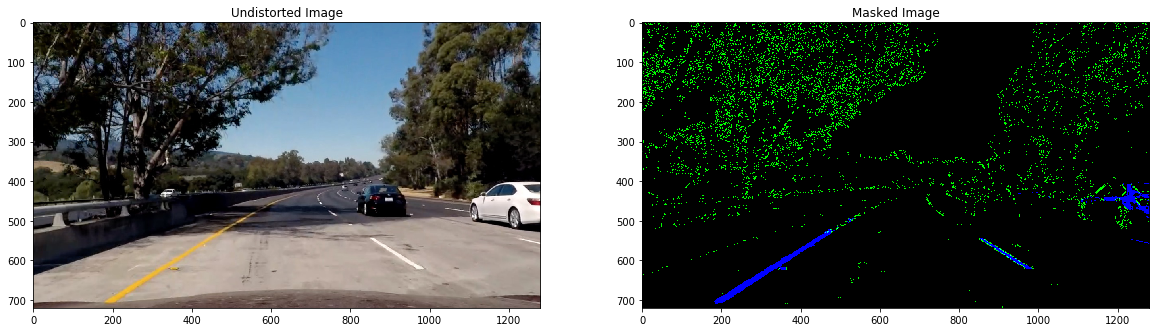

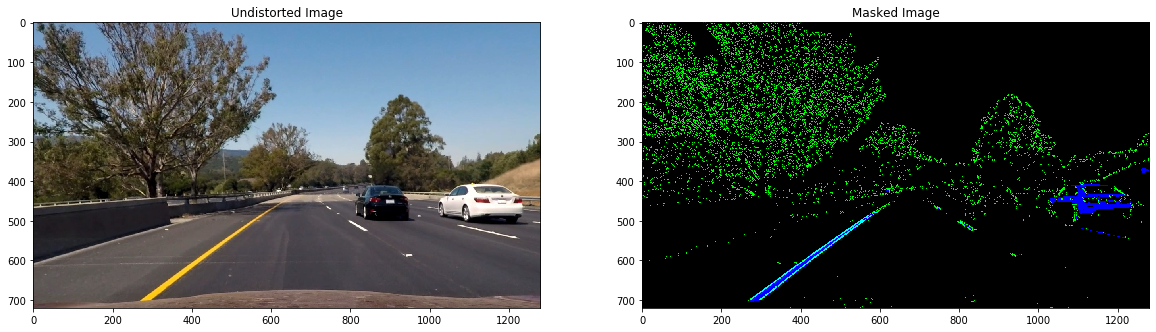

In [588]:
test_images = glob.glob('../test_images/*.jpg')
for fname in test_images:
    img = cv2.imread(fname)
    undistorted_img = undistort_image(img,objpoints,imgpoints)
    undistorted_img_rgb = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(undistorted_img, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(undistorted_img, orient='y', sobel_kernel=ksize, thresh=(10, 255))
    mag_binary = mag_thresh(undistorted_img, sobel_kernel=ksize, mag_thresh=(25, 255))
    dir_binary = dir_threshold(undistorted_img, sobel_kernel=ksize, thresh=(0.50, 1.10))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) | (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    hls_binary = hls_select(undistorted_img, s_thresh=(110, 255),l_thresh=(65, 255),h_thresh=(0, 60))
    
    combined_color_gradient = np.dstack(( np.zeros_like(combined), combined, hls_binary)) * 255

    # Vizualize undistorted image and masked image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Undistorted Image')
    ax1.imshow(undistorted_img_rgb)
    ax2.set_title('Masked Image')
    ax2.imshow(combined_color_gradient,cmap='gray');

## Apply a perspective transform to an image with straight lane lines:

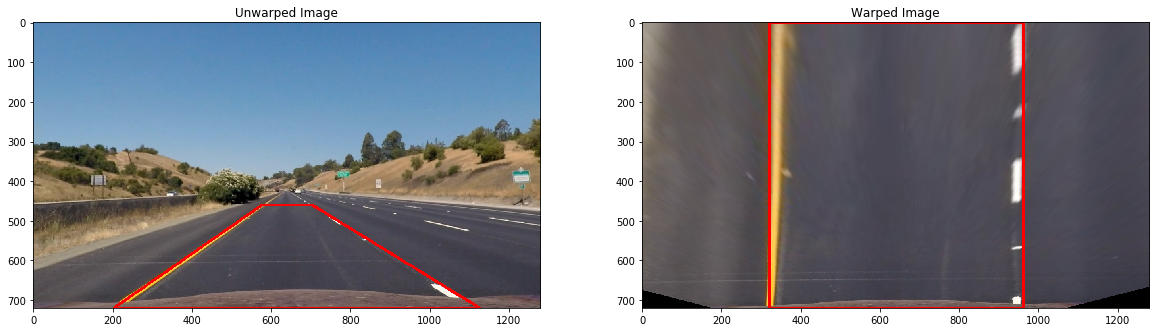

In [641]:
img = cv2.imread('../test_images/straight_lines1.jpg')
undistorted_img = undistort_image(img,objpoints,imgpoints)
undistorted_img_rgb = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)

img_size = (img.shape[1],img.shape[0])

src = np.float32(
[[(img_size[0] / 2) - 63, img_size[1] / 2 + 100],
[((img_size[0] / 6) - 10), img_size[1]],
[(img_size[0] * 5 / 6) + 60, img_size[1]],
[(img_size[0] / 2 + 63), img_size[1] / 2 + 100]])
dst = np.float32(
[[(img_size[0] / 4), 0],
[(img_size[0] / 4), img_size[1]],
[(img_size[0] * 3 / 4), img_size[1]],
[(img_size[0] * 3 / 4), 0]])


M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undistorted_img_rgb, M, img_size, flags=cv2.INTER_LINEAR)

unwarped_pts = np.array(src, np.int32)
unwarped_pts = unwarped_pts.reshape((-1,1,2))
cv2.polylines(undistorted_img_rgb,[unwarped_pts],True,(255,0,0),thickness=5)

warped_pts = np.array(dst, np.int32)
warped_pts = warped_pts.reshape((-1,1,2))
cv2.polylines(warped,[warped_pts],True,(255,0,0),thickness=5)


# Vizualize unwarped image and warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Unwarped Image')
ax1.imshow(undistorted_img_rgb)
ax2.set_title('Warped Image')
ax2.imshow(warped,cmap='gray');
